In [84]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

import torch 
from torch import nn
from torch import optim

from tqdm import tqdm

In [85]:
data_test = pd.read_csv(f'data/test.csv', index_col='id')
data_train = pd.read_csv(f'data/train.csv', index_col='id')

In [86]:
print(f'train shape: {data_train.shape}\ntest_shape: {data_test.shape}"')

train shape: (10407, 12)
test_shape: (6939, 11)"


In [87]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


In [88]:
np.arange(data_train.shape[1]).reshape(-1, 4).shape

(3, 4)

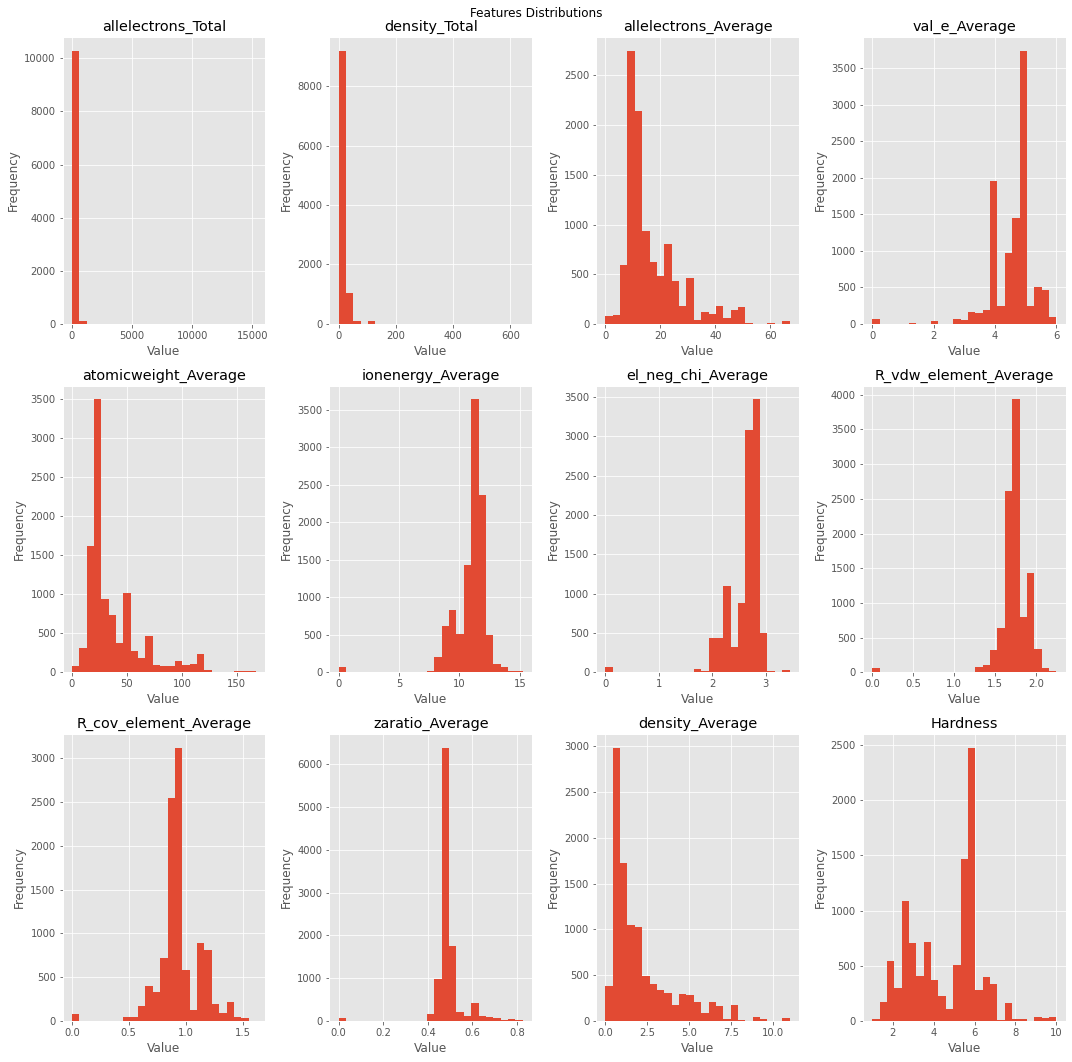

In [89]:
m, n = data_train.shape
grid = np.arange(n).reshape(-1, 4)
fig, axs = plt.subplots(grid.shape[0], grid.shape[1], figsize=(15,15), sharex=False)
counter = 0
plt.suptitle('Features Distributions')
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        feature_name = data_train.columns[counter]
        axs[i, j].hist(data_train[feature_name], bins=25)
        axs[i, j].set_title(feature_name)
        axs[i, j].set_xlabel('Value')
        axs[i, j].set_ylabel('Frequency')
        counter += 1
plt.tight_layout()
plt.show()

In [90]:
def IQR(col):
    arr = np.array(col.values)
    arr = np.sort(arr)
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    return q3 - q1

def Q3(col):
    arr = np.array(col.values)
    arr = np.sort(arr)
    return np.percentile(arr, 75)

def Q1(col):
    arr = np.array(col.values)
    arr = np.sort(arr)
    return np.percentile(arr, 25)

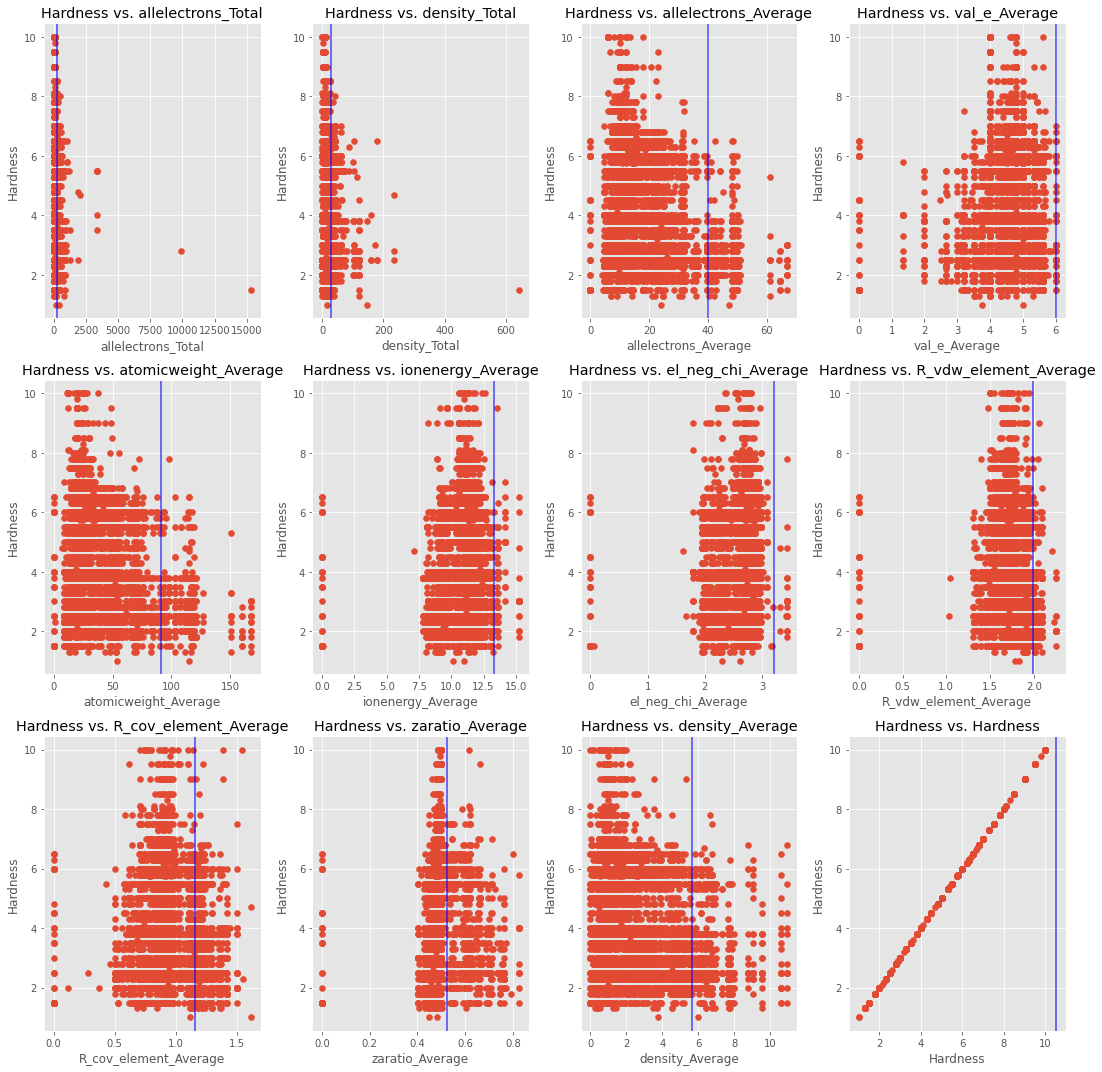

In [91]:
m, n = data_train.shape
grid = np.arange(n).reshape(-1, 4)
fig, axs = plt.subplots(grid.shape[0], grid.shape[1], figsize=(15,15))
counter = 0
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        feature_name = data_train.columns[counter]
        axs[i,j].scatter(x=data_train[feature_name], y=data_train['Hardness'])
        axs[i, j].set_title(f'Hardness vs. {feature_name}')
        axs[i, j].set_ylabel('Hardness')
        axs[i, j].set_xlabel(f'{feature_name}')
        axs[i, j].axvline(Q3(data_train[feature_name]) + IQR(data_train[feature_name]*1.5), c='blue', alpha=0.7)
        counter += 1
        
plt.tight_layout()
plt.show()

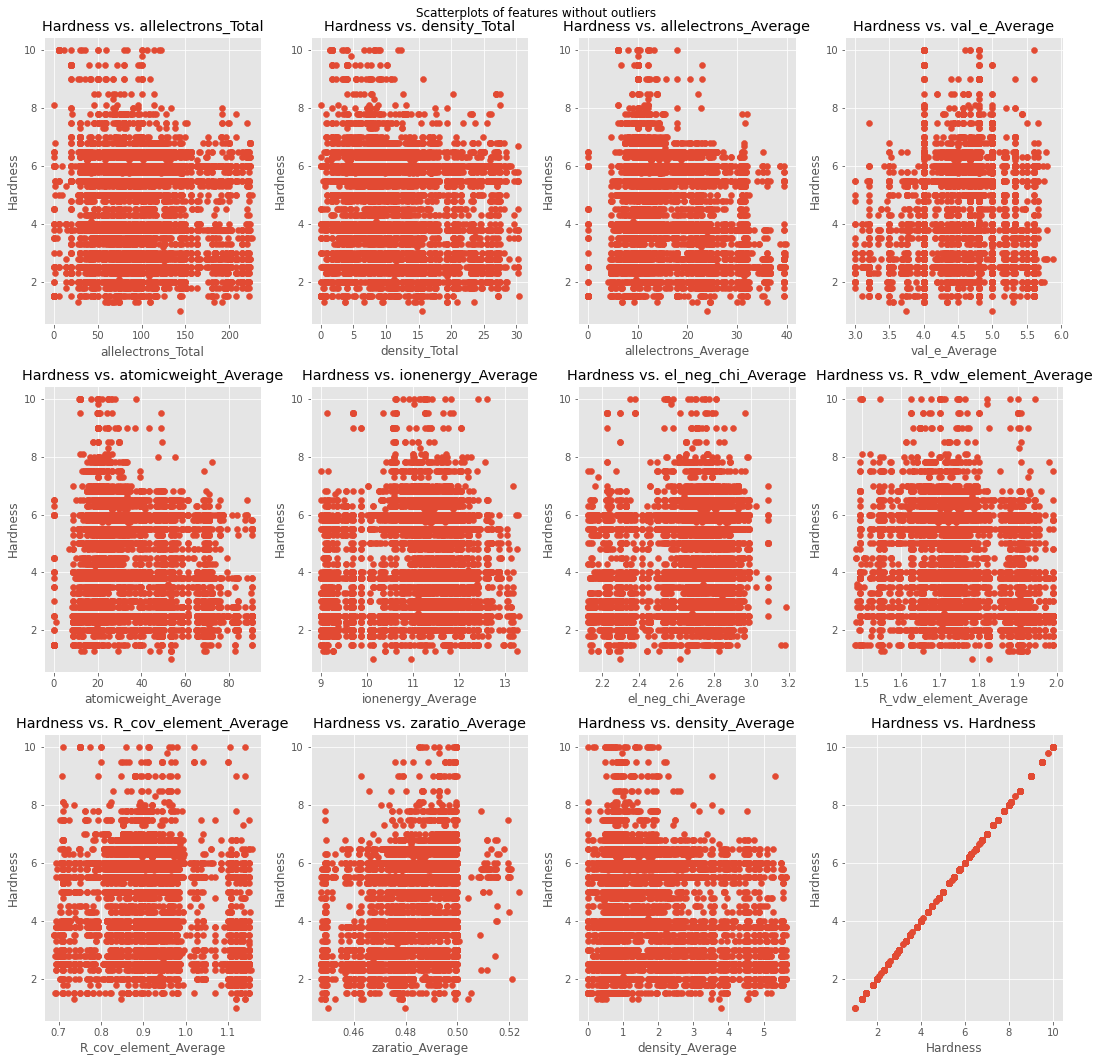

In [92]:
grid = np.arange(n).reshape(-1, 4)
fig, axs = plt.subplots(grid.shape[0], grid.shape[1], figsize=(15,15))
counter = 0
plt.suptitle("Scatterplots of features without outliers")
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        feature_name = data_train.columns[counter]
        # calc iqr and q3
        col_IQR = IQR(data_train[feature_name])
        col_Q3 = Q3(data_train[feature_name])
        col_Q1 = Q1(data_train[feature_name])
        # filter out the outliers
        col_no_outliers = data_train.loc[(data_train[feature_name] > col_Q1 - 1.5 * col_IQR) & (data_train[feature_name] < col_Q3 + 1.5 * col_IQR), [feature_name, 'Hardness']]
        # plot scatterplots
        axs[i,j].scatter(x=col_no_outliers[feature_name], y=col_no_outliers['Hardness'])
        axs[i, j].set_title(f'Hardness vs. {feature_name}')
        axs[i, j].set_ylabel('Hardness')
        axs[i, j].set_xlabel(f'{feature_name}')
        #axs[i, j].axvline(Q3(data_train[feature_name]) + IQR(data_train[feature_name]*1.5), c='blue', alpha=0.7)
        counter += 1
        
plt.tight_layout()
plt.show()

<AxesSubplot:>

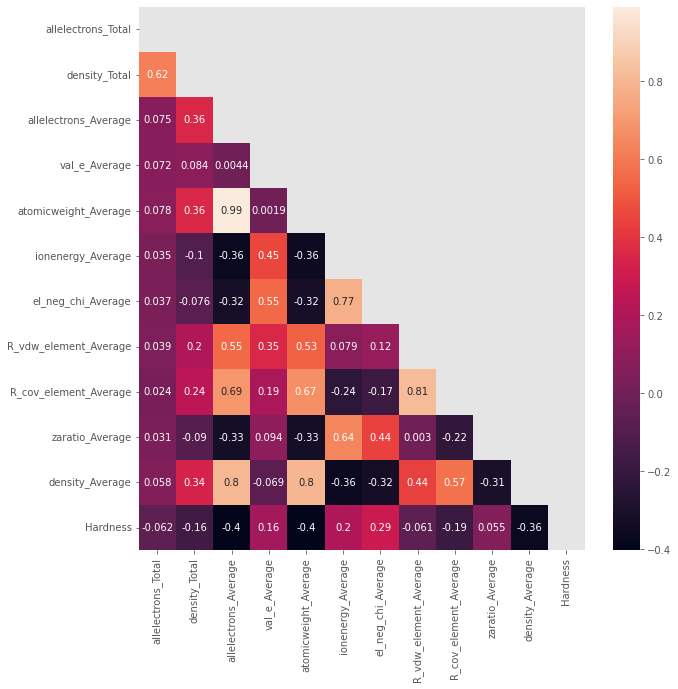

In [93]:
import seaborn as sns
# correlation matrix
corr = data_train.corr()
# mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(data_train.corr(), mask=mask, annot=True)

<AxesSubplot:title={'center':'Mean and Standard Deviation of each feature'}>

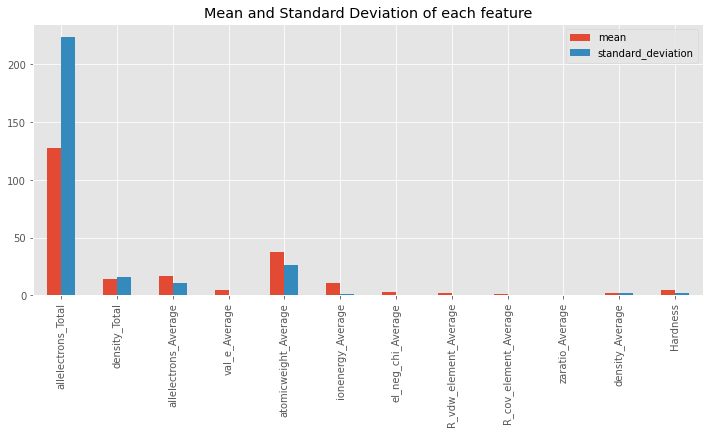

In [94]:
stat_df = pd.DataFrame([data_train.mean(), data_train.std()]).transpose()
stat_df = stat_df.rename({0: 'mean', 1: 'standard_deviation'}, axis=1)
stat_df.plot(kind='bar', title='Mean and Standard Deviation of each feature', figsize=(12,5))

___

In [96]:
data_train

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8


In [97]:
# divide train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(data_train.iloc[:, :11], data_train.iloc[:, -1], test_size=0.2)

In [101]:
# SVR pipe
n_components = 10
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('svr', SVR())
])

In [102]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('svr', SVR())])

In [104]:
y_hat = pipe.predict(X_val)

In [105]:
np.median(np.abs(np.array(y_val) - np.array(y_hat)))

0.6382919229062605

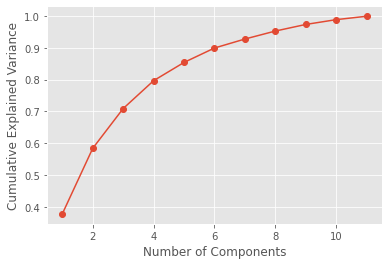

In [13]:
n_components = 11
pca = PCA(n_components=n_components)

principal_components = pca.fit_transform(data_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

___

In [19]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8325, 11), (2082, 11), (8325,), (2082,))

In [76]:
class NeuralNetRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(11, 24)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(24, 12)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(12, 6)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(6, 1)
        
    def forward(self, x):
        for layer, act in zip([self.layer1, self.layer2, self.layer3], [self.act1, self.act2, self.act3]):
            x = act(layer(x))
        x = self.output(x)
        return x
    
    def loss(self, yhat, y):
        return torch.median(torch.abs(y - yhat))
    
    # def optimize(self, lr):
    #     return optim.SGD(self.parameters, lr)


In [77]:
X_train = torch.from_numpy(X_train, type=torch.float32)
y_train = torch.from_numpy(y_train)
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)

TypeError: from_numpy() takes no keyword arguments

In [78]:
X_train = X_train.float()
y_train = y_train.float()
X_val = X_val.float()
y_val = y_val.float()

In [ ]:
learning_rate = 0.01

model = NeuralNetRegression()
optimizer_train = optim.SGD(model.parameters(), lr=learning_rate)
optimizer_val = optim.SGD(model.parameters(), lr=learning_rate)

train_loss_list = []
val_loss_list = []

num_iter = 300

for epoch in tqdm(range(num_iter), desc='NN Training'):
    # train score
    optimizer_train.zero_grad()
    
    yhat_train = model(X_train)
    train_loss = model.loss(yhat_train, y_train)
    train_loss.backward()
    # update parameters
    optimizer_train.step()
    # add loss to list
    train_loss_list.append(train_loss)
    
    # val score
    yhat_val = model(X_val)
    val_loss = torch.median(torch.abs(y_val - yhat_val))
    # add loss to list
    val_loss_list.append(val_loss)
    
    print(f'epoch: {epoch} / training loss: {train_loss.data} / validation loss: {val_loss.data}')


In [68]:


svr_model = svm.SVR()
svr_model.fit(X_train, y_train)

SVR()

In [71]:
yhat_svr_train = svr_model.predict(X_train)
yhat_svr_val = svr_model.predict(X_val)

In [80]:
svr_train_loss = torch.median(torch.abs(y_train - yhat_svr_train))
svr_val_loss = torch.median(torch.abs(y_val - yhat_svr_val))

In [81]:
svr_train_loss

tensor(0.3422, dtype=torch.float64)

In [82]:
svr_val_loss

tensor(0.3793, dtype=torch.float64)